In [125]:
import numpy as np
import librosa
import os
import glob
import warnings
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparseCoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.exceptions import ConvergenceWarning


In [162]:

# Feature extraction
def extract_features(audio_file):
    signal, sample_rate = librosa.load(audio_file, sr=None)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13)
    return mfcc.mean(axis=1)

# Load TIMIT dataset
data_dir = 'TIMIT/data'
train_dir = os.path.join(data_dir, 'TRAIN')

# Select a random subset of speakers for training
num_speakers_to_pick = 10  # Change this value to select a different number of speakers

all_speakers = []
dialects = os.listdir(train_dir)
for dialect in dialects:
    speakers = os.listdir(os.path.join(train_dir, dialect))
    all_speakers.extend(speakers)

selected_speakers = random.sample(all_speakers, num_speakers_to_pick)

print("Selected speakers:", selected_speakers)

# Load dataset. Use 80% of the sentences of each speaker for training and 20% for testing
X_train, y_train = [], []
X_test, y_test = [], []

dialects = os.listdir(train_dir)
for dialect in dialects:
    speakers = os.listdir(os.path.join(train_dir, dialect))
    for speaker in speakers:
        if speaker not in selected_speakers:
            continue
        audio_files = glob.glob(os.path.join(train_dir, dialect, speaker, '*.WAV'))
        np.random.shuffle(audio_files)
        num_sentences = len(audio_files)
        for i, audio_file in enumerate(audio_files):
            features = extract_features(audio_file)
            if i < num_sentences * 0.8:
                X_train.append(features)
                y_train.append(speaker)
            else:
                X_test.append(features)
                y_test.append(speaker)

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Number of speakers:', len(np.unique(y_train)))


Selected speakers: ['MHJB0', 'FEAC0', 'FLMA0', 'FPAD0', 'MSDS0', 'MAEB0', 'MRJB1', 'MRJM0', 'FBMJ0', 'MCPM0']
Number of speakers: 10


In [163]:

# Dictionary creation
dictionary = X_train.T

# Sparse representation
coder = SparseCoder(dictionary.T, transform_algorithm='lasso_lars', transform_alpha=1.)

# Classification
y_pred = []
for i, x in tqdm(enumerate(X_test)):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sparse_representation = coder.transform(x.reshape(1, -1))[0,:]

    residual = [
        np.linalg.norm(x - np.dot(dictionary[:, y_train == speaker], sparse_representation[y_train == speaker])) 
        for speaker in np.unique(y_train)
    ]
    y_pred.append(np.unique(y_train)[np.argmin(residual)])
    # print(np.min(residual), y_pred[i], y_test[i])

# Evaluation
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


20it [00:00, 617.02it/s]

Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

       FBMJ0       0.67      1.00      0.80         2
       FEAC0       0.67      1.00      0.80         2
       FLMA0       1.00      1.00      1.00         2
       FPAD0       1.00      0.50      0.67         2
       MAEB0       0.67      1.00      0.80         2
       MCPM0       1.00      0.50      0.67         2
       MHJB0       1.00      1.00      1.00         2
       MRJB1       0.00      0.00      0.00         2
       MRJM0       1.00      1.00      1.00         2
       MSDS0       1.00      1.00      1.00         2

    accuracy                           0.80        20
   macro avg       0.80      0.80      0.77        20
weighted avg       0.80      0.80      0.77        20



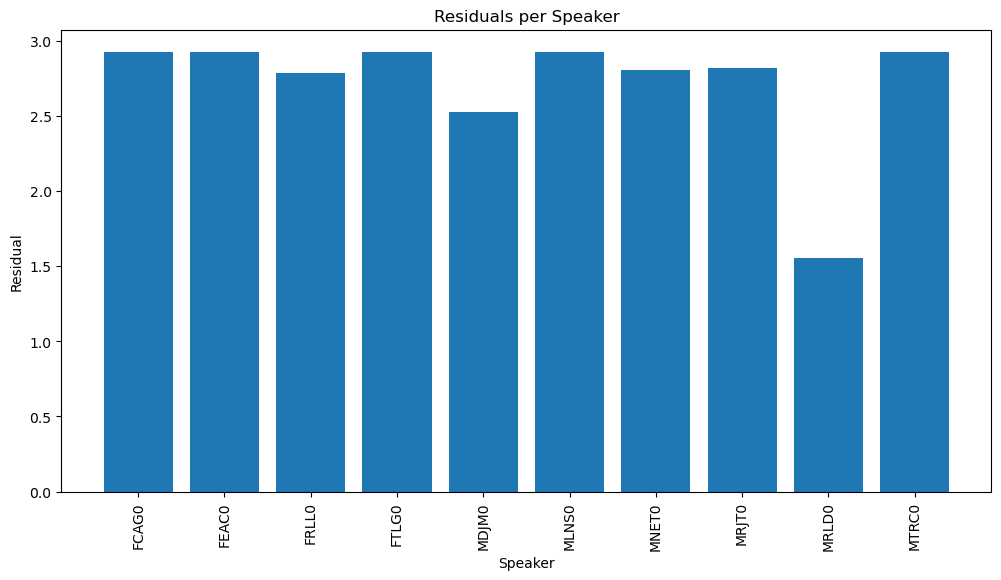

In [143]:
def plot_residuals(residuals, speakers, title='Residuals per Speaker'):
    plt.figure(figsize=(12, 6))
    plt.bar(speakers, residuals)
    plt.xlabel('Speaker')
    plt.ylabel('Residual')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
plot_residuals(residual, np.unique(y_train))

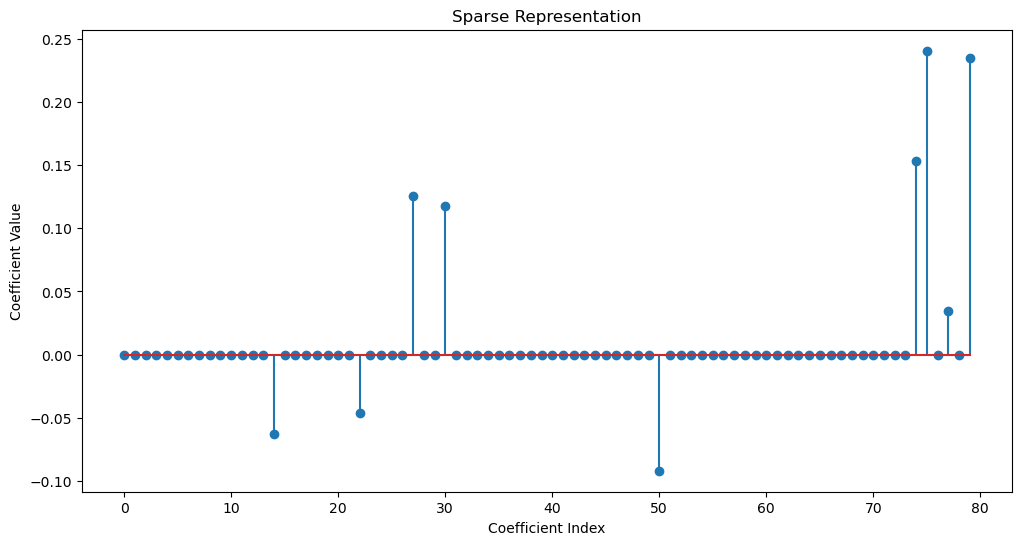

In [144]:
def plot_sparse_representation(sparse_representation, title='Sparse Representation'):
    plt.figure(figsize=(12, 6))
    plt.stem(sparse_representation, use_line_collection=True)
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.show()

# Assuming you have a sparse_representation array
plot_sparse_representation(sparse_representation)